# Sentiment Analysis on Twitter Data

This project builds an end-to-end sentiment analysis pipeline using both classical NLP techniques and deep learning models.  
A strong TF-IDF + Logistic Regression baseline is established first, followed by an LSTM-based sequence model to capture contextual sentiment.

The project emphasizes:
- proper preprocessing and feature engineering
- rigorous evaluation and error analysis
- fair comparison between classical and deep learning approaches

In [4]:
# Importing libraries
import pandas as pd
import numpy as np

In [5]:
columns = [
    "target",  # sentiment label
    "id",      # tweet id
    "date",    # tweet date
    "flag",    # quesry flag
    "user",    # username
    "text",    # tweet text
]
df = pd.read_csv(
    "data/Sentiment140.csv",
    encoding = "latin-1",
    names = columns
)

# Dataset Overview

In [6]:
df.shape

(1600000, 6)

In [7]:
df.head(100)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
95,0,1467836448,Mon Apr 06 22:26:27 PDT 2009,NO_QUERY,Dogbook,Strider is a sick little puppy http://apps.fa...
96,0,1467836500,Mon Apr 06 22:26:28 PDT 2009,NO_QUERY,natalieantipas,"so rylee,grace...wana go steve's party or not?..."
97,0,1467836576,Mon Apr 06 22:26:29 PDT 2009,NO_QUERY,timdonnelly,"hey, I actually won one of my bracket pools! T..."
98,0,1467836583,Mon Apr 06 22:26:29 PDT 2009,NO_QUERY,homeworld,"@stark YOU don't follow me, either and i work..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
df["target"].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [10]:
df["flag"].value_counts()

flag
NO_QUERY    1600000
Name: count, dtype: int64

In [11]:
df.duplicated().sum()

np.int64(0)

## Conclusion

The dataset consists of approximately 1.6 million tweets, where each row represents a single tweet along with associated metadata and a sentiment label.

### Target Variable

Sentiment labels are encoded as:
- 0 → Negative sentiment
- 4 → Positive sentiment

The dataset is approximately balanced across both classes. For modeling convenience, labels will be mapped to binary values (0 and 1).

### Feature Selection

Only the tweet text and sentiment label are retained for analysis.
Columns such as tweet ID, user, flag, and date are excluded as they do not provide predictive signal for sentiment classification within the scope of this project.

In [12]:
df1= df[["text", "target"]].copy()
df1["target"] = df1["target"].map({0: 0, 4: 1})

In [13]:
df1.shape

(1600000, 2)

In [14]:
df1.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


# Duplicate Handling

In [15]:
df1.duplicated().sum()

np.int64(16309)

In [16]:
df1 = df1.drop_duplicates(subset="text").reset_index(drop=True)

In [17]:
df1.shape

(1581466, 2)

Duplicate tweets were identified based on identical text content.
Approximately 1% of entries were duplicates and were removed to reduce redundancy and avoid potential bias.

# Text EDA

In [18]:
df1["text"].str.len().describe()

count    1.581466e+06
mean     7.447573e+01
std      3.620792e+01
min      6.000000e+00
25%      4.400000e+01
50%      7.000000e+01
75%      1.040000e+02
max      3.740000e+02
Name: text, dtype: float64

In [19]:
df1["text"].str.split().str.len().describe()

count    1.581466e+06
mean     1.324630e+01
std      6.924885e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      1.900000e+01
max      6.400000e+01
Name: text, dtype: float64

In [20]:
df1["text"].str.contains("http").mean()

np.float64(0.043533658010984744)

In [21]:
df1["text"].str.contains("@").mean()

np.float64(0.4702668283731677)

In [22]:
df1["text"].str.contains("#").mean()

np.float64(0.02305582288838331)

## Text EDA Insights

- Tweets are short in length, with a median of ~70 characters and ~12 words per tweet, confirming the short-text nature of the problem.
- Approximately 75% of tweets contain fewer than 20 words, supporting the use of a capped sequence length (e.g., ~30 tokens) for neural models.
- URLs appear in a small fraction of tweets (~4%) and do not contribute sentiment information, justifying their removal.
- User mentions are present in nearly half of the tweets (~47%) and are removed to reduce noise and vocabulary sparsity.
- Hashtags are relatively rare (~2%); however, the hashtag text may carry sentiment, so the `#` symbol will be removed while retaining the word.

# Preprocessing

## Preprocessing Design Decisions

- All text is lowercased to normalize tokens and reduce vocabulary sparsity.
- Stopword handling is model-specific: for the TF-IDF baseline, standard stopwords are removed while preserving negation words; for the LSTM model, stopwords are retained to preserve contextual and sequential information.
- URLs and user mentions are removed as they do not contribute to sentiment and introduce noise.
- Hashtag symbols are removed while retaining the hashtag text, as the words themselves may carry sentiment.
- Most punctuation is removed; however, sentiment-bearing punctuation such as exclamation marks and question marks is preserved or normalized.

In [23]:
import re

In [24]:
def clean_text_base(text):
    
    #Converting tecxt to lowercase
    text = text.lower()
    
    #Removing URLs
    text = re.sub(r"http\S+|www\S+", "",text)
    
    # Removing user mentions
    text = re.sub(r"@\w+","", text)
    
    #Removing hastag symbol but keeping the word
    text = re.sub(r"#", "", text)
    
    # Normalizing the punctuation
    text = re.sub(r"[!]{2,}","!", text)
    text = re.sub(r"[?]{2,}","?", text)
    
    return text.strip()

In [25]:
df2 = df1.copy()
df2["clean_text"] = df2["text"].apply(clean_text_base)

In [26]:
df2[["text", "clean_text"]].sample(5)

,text,clean_text
146470,"@THEArtistT Yeah, I don't that will happen. I...","yeah, i don't that will happen. i see 3rd wor..."
1527096,@SocialMediaMo Road Rage Tip - Don't mess wit...,road rage tip - don't mess with little old lad...
403287,is home very bored,is home very bored
1228592,@jackyoest @charmaineyoest am thinking AUL's n...,am thinking aul's new hire ought to be a sprin...
143816,Raining here now....Sabino out for today,raining here now....sabino out for today


**Preprocessing Summary**

Text preprocessing focused on reducing noise while preserving sentiment cues such as negations.  
These decisions were validated through manual inspection before downstream modeling.

# TF-IDF Feature Engineering & Classical Baseline Modeling

In [27]:
df2.head()

,text,target,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,- a that's a bummer. you shoulda got david ca...
1,is upset that he can't update his Facebook by ...,0,is upset that he can't update his facebook by ...
2,@Kenichan I dived many times for the ball. Man...,0,i dived many times for the ball. managed to sa...
3,my whole body feels itchy and like its on fire,0,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",0,"no, it's not behaving at all. i'm mad. why am ..."


## Train Validation Split Strategy

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
# Feature and Target
x = df2["clean_text"]
y = df2["target"]

In [31]:
# Train-Validation split
x_train, x_val, y_train, y_val = train_test_split(
    x,
    y,
    test_size = 0.2,
    random_state = 42,
    stratify = y
)

In [32]:
# Shape Check
print("Train size:", x_train.shape)
print("Validation size:", x_val.shape)

Train size: (1265172,)
Validation size: (316294,)


In [33]:
# Class distribution check
print("\nTrain label distribution:")
print(y_train.value_counts(normalize=True))


Train label distribution:
target
1    0.500346
0    0.499654
Name: proportion, dtype: float64


In [34]:
print("\nValidation label distribution:")
print(y_val.value_counts(normalize=True))


Validation label distribution:
target
1    0.500348
0    0.499652
Name: proportion, dtype: float64


**Train–Validation Split Summary**

The dataset was split into training and validation sets using an 80–20 ratio with stratification on the target label.  
This ensures that class distribution is preserved across both sets and prevents data leakage, since feature extraction techniques such as TF-IDF learn corpus-level statistics and must be fit only on training data.

## TF-IDF Specific Preprocessing

In [35]:
#Importing Library
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [36]:
#Negating words to preserve
NEGATIONS = {
    "no", "nor", "not",
    "don", "don't", "didn't", "doesn't",
    "won", "won't",
    "can't", "cannot",
    "isn't", "aren't", "wasn't", "weren't",
    "shouldn't", "wouldn't", "couldn't",
    "haven't", "hasn't", "hadn't"
}

In [37]:
# Create Custom stopword list
custom_stopwords = list(ENGLISH_STOP_WORDS.difference(NEGATIONS))

In [38]:
#Checking Stopwords
print("Default stopwords:", len(ENGLISH_STOP_WORDS))
print("Custom stopwords:", len(custom_stopwords))

Default stopwords: 318
Custom stopwords: 314


**Stopword Strategy Summary**

Default English stopwords were modified to preserve negation terms such as *not*, *no*, and *never*.  
This prevents loss of sentiment polarity and ensures that negation-based expressions remain meaningful during TF-IDF feature extraction.

**N-gram Configuration**

Both unigrams and bigrams are used during TF-IDF vectorization.  
Unigrams capture individual sentiment-bearing words, while bigrams capture short phrases and local context, particularly negation patterns such as *not good* or *never liked*.

# TF-IDF Vectorization
## TF-IDF Configuration

In [39]:
# Importing library
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
# Tf-IDF Vectorizer Intialization
tfidf_vectorizer = TfidfVectorizer(
    stop_words = custom_stopwords,
    ngram_range = (1, 2),
    max_features = 50000,
    min_df = 5,
    max_df = 0.9,
    sublinear_tf = True
)

**TF-IDF Configuration Summary**

TF-IDF vectorization is configured to capture both individual words and short phrases while controlling feature space size and noise.  
Rare terms and overly frequent terms are filtered to improve generalization, and sublinear term frequency scaling is applied to reduce the impact of repeated words.

## TF-IDF Fitting and Transformation

In [41]:
# Fit TF-IDF on training data
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

In [42]:
# Transformvalidation data
x_val_tfidf = tfidf_vectorizer.transform(x_val)

In [43]:
# Shape Inspection
print("training TF-TDF shape:", x_train_tfidf.shape)
print("Validation TF-IDF shape:", x_val_tfidf.shape)

training TF-TDF shape: (1265172, 50000)
Validation TF-IDF shape: (316294, 50000)


**TF-IDF Fitting and Transformation**

The TF-IDF vectorizer was fit on the training dataset and subsequently applied to the validation dataset using the same learned vocabulary.  
This ensures consistent feature representation and prevents information leakage.

# Feature Matrix Validation
## Shape and Consistency Check

In [44]:
# Number of features (Vocubulary Size)
num_features = x_train_tfidf.shape[1]

In [45]:
print("Number of TF-IDF features:", num_features)
print("Train samples:",x_train_tfidf.shape[0])
print("Validation samples:",x_val_tfidf.shape[0])

Number of TF-IDF features: 50000
Train samples: 1265172
Validation samples: 316294


**Feature Matrix Shape Validation**

The TF-IDF feature matrices were inspected to ensure consistent dimensionality across training and validation sets.  
Both datasets share the same feature space, confirming that the vectorizer vocabulary was learned exclusively from the training data.

## Vocabulary Sanity Check

In [46]:
# Size of Vocabulary
print("Vocabulary size:", len(tfidf_vectorizer.vocabulary_))

Vocabulary size: 50000


In [47]:
# Inspect a small sample of learned features
print(list(tfidf_vectorizer.vocabulary_.keys()))[:30]

['amp', 'mos', 'likely', 'no', 'gotta', 'work', 'lol', 'work lol', 'happy', 'anniversary', 'today', 'years', '7th', 'love', 'honey', 'happy anniversary', 'anniversary today', 'love honey', 'wanna', 'friends', 'anybody', 'im', 'bored', 'wanna friends', 'im bored', 'maybe', 'did', 'aa', 'maybe did', 'amazing', 'idea', 'amazing no', 'no idea', 'boy', 'cute', 'don', 'need', 'daddy', 'don need', 'update', 'site', 'near', 'real', 'time', 'real time', 'oh', 've', 'saw', 'profile', 'followed', 'thanks', 'lurking', 'oh no', 'no ve', 'susan', 'boyle', 'wins', 'like', 'grrrr', 'annoyed', 'okay', 'doesn', 'talent', 'dancers', 'xx', 'susan boyle', 'hey', 'stalker', 'guess', 'tomorrow', 'class', 'tomorrow time', 'internet', 'spread', 'look', 'tv', 'news', 'break', 'big', 'stories', 'taking', 'challenge', 'semester', 'finals', 'dog', 'just', 'fit', 'dog just', 'haha', 'omgsh', 'cause', 'hes', 'hes just', 'just amazing', 'amazing like', 'awww', 'wonderful', 'ur', 'son', 'smooth', 'sailing', 'yes', 'ra

TypeError: 'NoneType' object is not subscriptable

**Vocabulary Inspection**

A sample of learned TF-IDF features was inspected to verify semantic relevance.  
The vocabulary contains sentiment-bearing unigrams as well as contextual bigrams, indicating that preprocessing and vectorization were applied correctly.

## Sparsity Check

In [48]:
# Calculate Sparsity
train_nonzero = x_train_tfidf.nnz
train_total = x_train_tfidf.shape[0]*x_train_tfidf.shape[1]

sparsity = 1 - (train_nonzero / train_total)

print(f"Training TF-IDF sparsity: {sparsity:.4f}")

Training TF-IDF sparsity: 0.9998


**Sparsity Analysis**

The TF-IDF feature matrix is highly sparse, with the majority of feature values being zero.  
This sparsity is expected for text data and is well-suited for linear models such as Logistic Regression.

# Baseline Model Selection: Logistic Regression

In [49]:
# Importing Library
from sklearn.linear_model import LogisticRegression

In [50]:
# Logistic Regression Intialization
log_reg = LogisticRegression(
    penalty = "l2",
    C= 1.0,
    solver = "liblinear",
    max_iter = 1000,
    class_weight = "balanced",
    random_state = 42
)

**Baseline Model Selection**

Logistic Regression was selected as the baseline classifier due to its effectiveness on high-dimensional sparse feature representations produced by TF-IDF.  
L2 regularization and class balancing were applied to improve generalization and handle potential class imbalance.

# Model Training

In [51]:
# Training Logistic Regression
log_reg.fit(x_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [52]:
# Predict class labels
y_val_pred = log_reg.predict(x_val_tfidf)

In [53]:
# Predict probabilities
y_val_proba = log_reg.predict_proba(x_val_tfidf)[:, 1]

**Model Training**

The Logistic Regression model was trained on TF-IDF features extracted from the training dataset.  
Predictions and class probabilities were generated for the validation set to support comprehensive model evaluation.

# Baseline Model Evaluation
## Classification Metrics

In [54]:
# Importing Library
from sklearn.metrics import accuracy_score, classification_report

In [55]:
# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4}")

Validation Accuracy: 0.7969


In [56]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names = ["Negative", "Positive"]))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.78      0.79    158037
    Positive       0.79      0.82      0.80    158257

    accuracy                           0.80    316294
   macro avg       0.80      0.80      0.80    316294
weighted avg       0.80      0.80      0.80    316294



**Classification Metrics**

Model performance was evaluated using accuracy, precision, recall, and F1-score.  
The results indicate balanced performance across sentiment classes, demonstrating that the TF-IDF and Logistic Regression baseline captures sentiment signals effectively.

## Confusion Matrix

In [57]:
#Importing Libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
cm = confusion_matrix(y_val, y_val_pred)

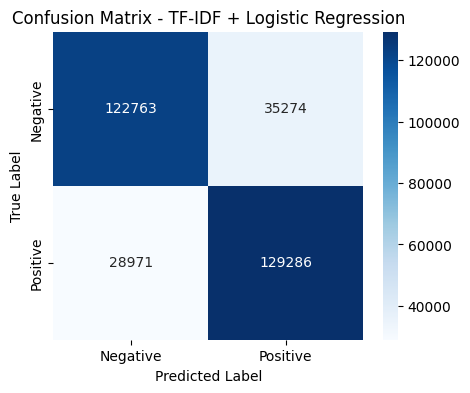

In [59]:
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TF-IDF + Logistic Regression")
plt.show()

**Confusion Matrix Analysis**

The confusion matrix was analyzed to understand the distribution of correct and incorrect predictions across sentiment classes.  
The results indicate a balanced error distribution, with no strong bias toward either positive or negative sentiment.

## Qualitative Error Analysis

In [60]:
# Create a dataframe for error analysis
error_df = df2.loc[x_val.index].copy()
error_df["prediction"] = y_val_pred

In [61]:
# View some misclassified examples
error_df[error_df["prediction"] != error_df["target"]].head(10)[
    ["text", "clean_text", "target", "prediction"]
]

,text,clean_text,target,prediction
1003439,@miasuraya over a yr ago. buat per situ? how ...,over a yr ago. buat per situ? how long u puny...,1,0
730708,hopes to chat with her best friend tonight ht...,hopes to chat with her best friend tonight,0,1
986706,@Rebecca8888 aww i knoooo! (}) nd kk snnd i w...,aww i knoooo! (}) nd kk snnd i will try is i...,1,0
1337338,"@SignWerks do this, don't do that, can't you r...","do this, don't do that, can't you read the sig...",1,0
1313033,Just finished work and just got hired again......,just finished work and just got hired again......,1,0
1211311,@yikes77 Ohh u gotta plan for that? Ouch!! LOL...,ohh u gotta plan for that? ouch! lol! guess i'...,1,0
981206,@thatpatti let's get two others and play!! wan...,let's get two others and play! wanna?,1,0
231601,New possible master is down to one. Haven't me...,new possible master is down to one. haven't me...,0,1
550252,@nodinosaur @ChrisSQC I duno interface is cool...,"i duno interface is cool, but still they some ...",0,1
1507443,"No matter what, you are still my best friend, ...","no matter what, you are still my best friend, ...",1,0


**Qualitative Error Analysis**

Manual inspection of misclassified tweets revealed several recurring patterns.  
Errors frequently occurred in tweets expressing sentiment implicitly through events or intent rather than explicit sentiment words, as well as in highly informal language containing slang, elongations, or phonetic spellings.  
Additionally, some misclassifications involved mixed or polite language that masked underlying sentiment, and negation-heavy instructional phrases where intent was difficult to infer using bag-of-words representations.  
These observations highlight the limitations of TF-IDF in capturing contextual and sequential information.

## Baseline Summary and Learnings

The TF-IDF and Logistic Regression baseline achieved strong performance on the Sentiment140 dataset, with balanced precision, recall, and F1-scores across both sentiment classes. This confirms that classical bag-of-words representations remain highly effective for short-text sentiment classification.

Feature inspection and qualitative error analysis revealed that most misclassifications occurred in tweets expressing sentiment implicitly through events, informal language, or context-dependent phrasing. These cases highlight the limitations of TF-IDF in capturing word order, contextual meaning, and sequential dependencies.

Based on these observations, further performance improvements are more likely to come from models that can capture sequence-level and contextual information rather than additional tuning of TF-IDF features. This motivates the transition to a deep learning approach using recurrent neural networks in the next phase.

# Deep Learning for Sentiment Analysis using LSTM

## Why Move from TF-IDF to LSTM

TF-IDF represents text as an unordered collection of words or phrases and does not preserve sequence information. As a result, it struggles with sentiment expressed through context, event descriptions, sarcasm, or subtle phrasing.

LSTM models overcome these limitations by:

processing text as ordered sequences

maintaining contextual memory across words

learning dependencies between earlier and later parts of a sentence

Based on the error patterns observed in the baseline model, an LSTM-based approach is a natural next step.

## Data Preparation for Deep Learning Models

In [62]:
# Importing Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [64]:
# Tokenization
MAX_VOCAB_SIZE = 50000

tokenizer = Tokenizer(
    num_words = MAX_VOCAB_SIZE,
    oov_token = "<OOV>"
)
tokenizer.fit_on_texts(x_train)

**Tokenization**

A Keras tokenizer was used to convert cleaned text into integer tokens.  
The tokenizer was fit exclusively on the training data to prevent information leakage, with vocabulary size limited to the most frequent words.

In [67]:
# Text to sequence conversion
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)

print("Original text:", x_train.iloc[0])
print("\n Tokenized Sequence:", x_train_seq[0])

Original text: where? &amp; mos likely no, gotta go2 work  lol

 Tokenized Sequence: [213, 64, 7403, 2187, 37, 304, 21527, 47, 49]


**Text to Sequence Conversion**

Cleaned text was transformed into sequences of integer tokens while preserving word order, enabling sequential modeling.

In [69]:
# Sequence Length Analysis
sequence_lengths = [len(seq) for seq in x_train_seq]

print("Mean length:",np.mean(sequence_lengths))
print("Median length:",np.median(sequence_lengths))
print("95th percentile:",np.percentile(sequence_lengths,95))



Mean length: 12.814381759950425
Median length: 12.0
95th percentile: 25.0


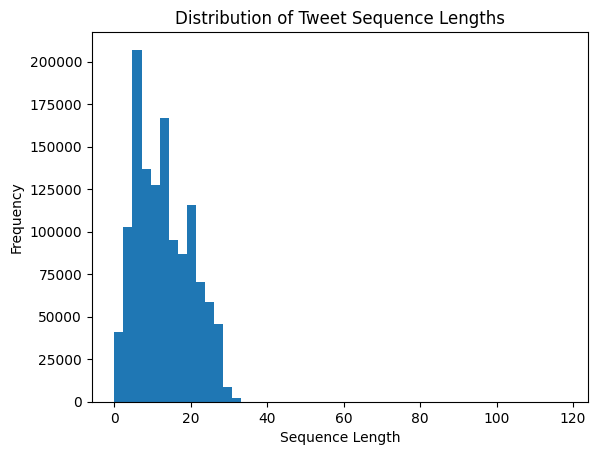

In [71]:
plt.hist(sequence_lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Sequence Lengths")
plt.show()

**Sequence Length Analysis**

Based on the sequence length distribution, a maximum sequence length of 25 tokens was selected.  
This choice captures approximately 95% of tweets while minimizing unnecessary padding, resulting in a more efficient and stable LSTM training process.

In [72]:
#Importing Libraries for padding and truncation
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [74]:
# Padding & Truncation

MAX_SEQUENCE_LENGTH = 25

x_train_pad = pad_sequences(
    x_train_seq,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
    truncating="post"
)

x_val_pad = pad_sequences(
    x_val_seq,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
    truncating="post"
)

In [75]:
#Shape Check
print("Padded train Shape:", x_train_pad.shape)
print("Padded Validation Shape:", x_val_pad.shape)

Padded train Shape: (1265172, 25)
Padded Validation Shape: (316294, 25)


**Sequence Padding and Truncation**

Tokenized sequences were padded and truncated to a fixed length of 25 tokens to ensure uniform input dimensions for the LSTM model.  
Post-padding and post-truncation were applied to preserve the initial context of each tweet while minimizing unnecessary padding.

## Word Embedding Strategy

Word embeddings are used to convert integer token sequences into dense vector representations that capture semantic relationships between words. These representations enable the LSTM model to learn meaningful patterns from text data.

In this project, trainable embeddings are used instead of pretrained embeddings. This choice is motivated by the large dataset size and the informal, domain-specific nature of Twitter text, which benefits from embeddings learned directly from the data.

An embedding dimension of 128 is selected to balance representational power and computational efficiency. The embedding layer is configured to be trainable and handles padding tokens implicitly.

## LSTM Model Architecture

In [82]:
# Importing Libraries for building LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Input

In [83]:
# Building LSTM Model

VOCAB_SIZE = 50000
EMBEDDING_DIM = 128
MAX_SEQUENCE_LENGTH = 25

model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,)),
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQUENCE_LENGTH
    ),
    LSTM(
        units=64,
        dropout=0.2,
        recurrent_dropout=0.2
    ),
    Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 25, 128)        │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,449,473 (24.60 MB)

 Trainable params: 6,449,473 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

**LSTM Model Architecture**

The LSTM model consists of a trainable embedding layer, a single LSTM layer with dropout regularization, and a sigmoid-activated output layer.  
The architecture is designed to capture sequential dependencies in tweet text while remaining computationally efficient for large-scale training.

## Model Compilation & Training Regularization

In [86]:
# Importing libraries for compilation and training regularization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [85]:
#Model Compilation
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

**Model Compilation**

The model was compiled using the Adam optimizer with binary cross-entropy loss.  
This configuration supports stable and efficient optimization for large-scale binary sentiment classification.

In [87]:
# Training Regularization
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

**Training Regularization**

Early stopping was applied based on validation loss to prevent overfitting and restore the best-performing model weights.

## LSTM Model Training & Evaluation

In [88]:
# Model Training
history = model.fit(
    x_train_pad,
    y_train,
    validation_data=(x_val_pad, y_val),
    epochs=10,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 475s 95ms/step - accuracy: 0.8001 - loss: 0.4311 - val_accuracy: 0.8203 - val_loss: 0.3974
Epoch 2/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 478s 97ms/step - accuracy: 0.8303 - loss: 0.3773 - val_accuracy: 0.8260 - val_loss: 0.3860
Epoch 3/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 499s 101ms/step - accuracy: 0.8430 - loss: 0.3525 - val_accuracy: 0.8263 - val_loss: 0.3886
Epoch 4/10
4943/4943 ━━━━━━━━━━━━━━━━━━━━ 481s 97ms/step - accuracy: 0.8542 - loss: 0.3306 - val_accuracy: 0.8246 - val_loss: 0.3991


**Model Training**

The LSTM model was trained on padded tweet sequences with validation performance monitored at each epoch.  
Early stopping was applied to prevent overfitting and ensure efficient training.

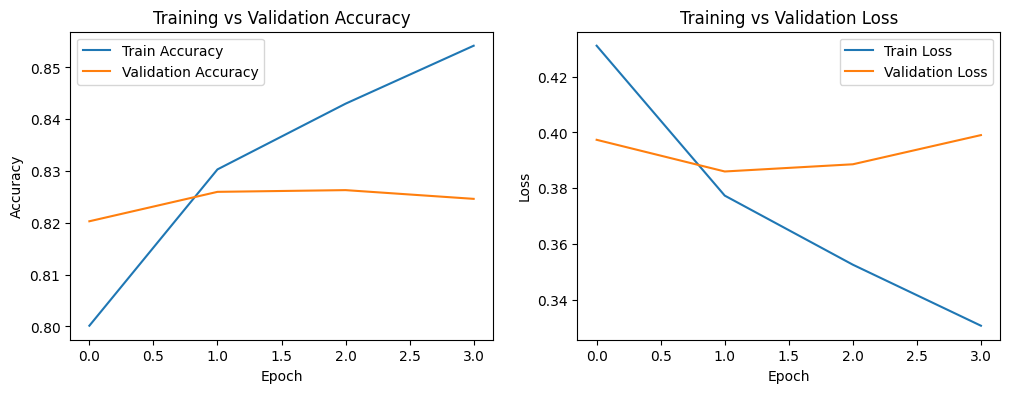

In [89]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()

**Training Curve Analysis**

Training and validation curves were inspected to assess convergence behavior and potential overfitting.  
Early stopping helped stabilize validation performance.

In [91]:
# Generating Prediction
y_val_pred_lstm = (model.predict(x_val_pad) > 0.5).astype(int).ravel()

9885/9885 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step


In [92]:
# Importing Library for Classificatiob Metrics
from sklearn.metrics import accuracy_score, classification_report

In [94]:
# Classification_metrics
accuracy_lstm = accuracy_score(y_val, y_val_pred_lstm)
print(f"Validation Acuuracy (LSTM): {accuracy_lstm:.4f}")
print("\nClassification Report (LSTM)")
print(classification_report(y_val, y_val_pred_lstm, target_names=["Negative", "Positive"]))

Validation Acuuracy (LSTM): 0.8260

Classification Report (LSTM)
              precision    recall  f1-score   support

    Negative       0.82      0.83      0.83    158037
    Positive       0.83      0.82      0.83    158257

    accuracy                           0.83    316294
   macro avg       0.83      0.83      0.83    316294
weighted avg       0.83      0.83      0.83    316294



**LSTM Model Results**

The LSTM-based model achieved a validation accuracy of approximately 82.6%, outperforming the TF-IDF and Logistic Regression baseline.  
Performance improvements were consistent across both sentiment classes, with balanced precision and recall.

The observed gains indicate that sequence-based modeling is effective in capturing contextual and implicit sentiment patterns that are not well represented by bag-of-words approaches. However, the results also highlight that classical TF-IDF models remain strong baselines for short-text sentiment analysis.

# Model Comparison, Trade-offs, and Final Conclusions

This phase compares the classical TF-IDF–based model and the LSTM-based deep learning model to evaluate their performance, strengths, and practical trade-offs for sentiment analysis on Twitter data.

## Performance Comparison

Both models were evaluated on the same validation dataset using identical metrics to ensure a fair comparison.

### Model---------------------------Accuracy-----Macro F1

TF-IDF + Logistic Regression----- ~0.80------ ~0.80

LSTM (Sequence-based)------------- ~0.83------- ~0.83

The LSTM model achieved a modest but consistent improvement over the TF-IDF baseline, with balanced performance across both sentiment classes.

## Error Pattern Comparison

Qualitative analysis revealed that the TF-IDF model struggled with implicit sentiment expressed through events, informal language, and context-dependent phrasing. Additionally, the lack of word-order awareness limited its ability to handle negation and subtle sentiment cues.

The LSTM model reduced errors in these cases by modeling word order and contextual dependencies, resulting in improved classification of nuanced sentiment expressions.

## Model Complexity and Practical Trade-offs

While the LSTM model outperformed the TF-IDF baseline, it introduced additional computational complexity.

TF-IDF + Logistic Regression

Fast training and inference

Low memory footprint

High interpretability

Strong baseline performance

LSTM

Higher computational cost

Longer training time

Lower interpretability

Better handling of contextual and sequential sentiment

The choice between these models depends on deployment constraints and performance requirements.

## Final Observations

The results demonstrate that classical NLP approaches remain highly effective for short-text sentiment analysis, while sequence-based deep learning models provide meaningful improvements when contextual understanding is required.

Rather than replacing classical methods, deep learning complements them by addressing specific limitations related to context and sequence modeling.

## Project Summary

This project implemented an end-to-end sentiment analysis pipeline, including:

dataset understanding and preprocessing

TF-IDF feature engineering and classical baseline modeling

quantitative and qualitative evaluation

LSTM-based deep learning modeling

fair comparison and informed conclusions

The final solution reflects industry-grade practices in model design, evaluation, and decision-making.